# Clasificador de Propinas para Viajes en Taxi en NYC (2020)

Inspirado en la charla ["Keeping up with Machine Learning in Production"](https://github.com/shreyashankar/debugging-ml-talk) de [Shreya Shankar](https://twitter.com/sh_reya)


Este notebook muestra la construcción de un modelo de machine learning de juguete, usando datos de viajes de los taxis amarillos de Nueva York para el año 2020, [proporcionados por la NYC Taxi and Limousine Commission (TLC)](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

La idea es encontrar aquellos viajes donde la propina dejada por el pasajero fue alta, es decir, mayor al 20% del costo del viaje.

Para ello ajustaremos un modelo de classificación binaria RandomForest usando los datos de los viajes de enero de 2020. Probaremos el modelo resultante sobre los datos de los viajes de febrero de 2020. Compararemos el desempeño del modelo en ambos casos usando la métrica de [f1-score](https://en.wikipedia.org/wiki/F-score).

**Este notebook está construido para ser ejecutado en [Google Colab](https://colab.research.google.com/), al que podemos acceder de manera gratuita solo teniendo un usuario de Google (Gmail) y un navegador web. No es necesario instalar nada en el computador local.**

## Cargando las librerías necesarias

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

## Leemos los datos de enero 2020 (entrenamiento)

In [2]:
taxi = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-01.parquet')

In [3]:
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,None
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,None
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,None
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,None
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,None


In [4]:
taxi.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

## Descripción del Dataset

El diccionario de los datos puede encontrarse [acá](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf):

| Field Name      | Description |
| ----------- | ----------- |
| VendorID      | A code indicating the TPEP provider that provided the record. 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.       |
| tpep_pickup_datetime   | The date and time when the meter was engaged.        |
| tpep_dropoff_datetime   | The date and time when the meter was disengaged.        |
| Passenger_count   | The number of passengers in the vehicle. This is a driver-entered value.      |
| Trip_distance   | The elapsed trip distance in miles reported by the taximeter.      |
| PULocationID   | TLC Taxi Zone in which the taximeter was engaged.      |
| DOLocationID   | TLC Taxi Zone in which the taximeter was disengaged      |
| RateCodeID   | The final rate code in effect at the end of the trip. 1= Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride     |
| Store_and_fwd_flag | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. Y= store and forward trip, N= not a store and forward trip |
| Payment_type | A numeric code signifying how the passenger paid for the trip. 1= Credit card, 2= Cash, 3= No charge, 4= Dispute, 5= Unknown, 6= Voided trip |
| Fare_amount | The time-and-distance fare calculated by the meter. |
| Extra | Miscellaneous extras and surcharges. Currently, this only includes the \$0.50 and \$1 rush hour and overnight charges. |
| MTA_tax | \$0.50 MTA tax that is automatically triggered based on the metered rate in use. |
| Improvement_surcharge | \$0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
| Tip_amount | Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip. |
| Total_amount | The total amount charged to passengers. Does not include cash tips. |

## Definimos las características con las que realizaremos la clasificación.

Las construiremos a continuación en la etapa de pre-procesamiento de los datos.

In [5]:
numeric_feat = [
    "pickup_weekday",
    "pickup_hour",
    'work_hours',
    "pickup_minute",
    "passenger_count",
    'trip_distance',
    'trip_time',
    'trip_speed'
]
categorical_feat = [
    "PULocationID",
    "DOLocationID",
    "RatecodeID",
]
features = numeric_feat + categorical_feat
EPS = 1e-7

In [6]:
def preprocess(df, target_col):

   # Basic cleaning
    df = df[df['fare_amount'] > 0].reset_index(drop=True)  # avoid divide-by-zero
    # add target
    df['tip_fraction'] = df['tip_amount'] / df['fare_amount']
    df[target_col] = df['tip_fraction'] > 0.2

    # add features
    df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute
    df['work_hours'] = (df['pickup_weekday'] >= 0) & (df['pickup_weekday'] <= 4) & (df['pickup_hour'] >= 8) & (df['pickup_hour'] <= 18)
    df['trip_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds
    df['trip_speed'] = df['trip_distance'] / (df['trip_time'] + EPS)

    # drop unused columns
    df = df[['tpep_dropoff_datetime'] + features + [target_col]]
    df[features + [target_col]] = df[features + [target_col]].astype("float32").fillna(-1.0)

    # convert target to int32 for efficiency (it's just 0s and 1s)
    df[target_col] = df[target_col].astype("int32")

    return df.reset_index(drop=True)


In [7]:
target_col = "high_tip"

taxi_train = preprocess(df=taxi, target_col=target_col)

In [8]:
print(f'Num rows: {len(taxi_train)}, Size: {taxi_train.memory_usage(deep=True).sum() / 1e9} GB')

Num rows: 6382762, Size: 0.3574348 GB


## Ajustamos el modelo con los datos de entrenamiento

Este proceso se puede demorar bastante (¡en mi caso fueron 30 minutos!), pero podemos realizar una prueba mas pequeña reduciendo la cantidad de ejemplos de entrenamiento. Por ejemplo podríamos agregar la siguiente celda:

`taxi_train = taxi_train.head(100000)`

In [9]:
taxi_train = taxi_train.head(100000)

In [10]:
%%time

rfc = RandomForestClassifier(n_estimators=100, max_depth=10)

rfc.fit(taxi_train[features], taxi_train[target_col])

CPU times: user 14.9 s, sys: 136 ms, total: 15.1 s
Wall time: 21 s


RandomForestClassifier(max_depth=10)

## Calculamos la métrica f1-score en el conjunto de entrenamiento

In [11]:
%%time
# Compute F1

preds = rfc.predict_proba(taxi_train[features])

CPU times: user 1.16 s, sys: 7.29 ms, total: 1.17 s
Wall time: 1.27 s


In [12]:
preds

array([[0.39485948, 0.60514052],
       [0.40088824, 0.59911176],
       [0.48311676, 0.51688324],
       ...,
       [0.4600073 , 0.5399927 ],
       [0.39456299, 0.60543701],
       [0.43427298, 0.56572702]])

In [13]:
preds_labels = [p[1] for p in preds.round()]

In [14]:
preds_labels[0:10]

[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [15]:
print(f'F1: {f1_score(taxi_train[target_col], preds_labels)}')

F1: 0.6567521032018627


## Exportamos el modelo a un archivo

In [16]:
import joblib

joblib.dump(rfc, "random_forest.joblib")

['random_forest.joblib']

El archivo aparecerá en el menú del lado izquierdo, como se muestra en la foto. Podemos guardarlo en nuestro equipo usando boton derecho -> Download. Será útil hacerlo porque lo seguiremos usando en el futuro.

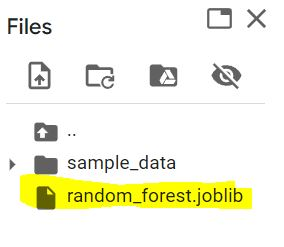

## Cargamos los datos de febrero 2020 (prueba)

In [17]:
taxi_feb = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-02.parquet')
taxi_test = preprocess(taxi_feb, target_col=target_col)
taxi_test.head()

,tpep_dropoff_datetime,pickup_weekday,pickup_hour,work_hours,pickup_minute,passenger_count,trip_distance,trip_time,trip_speed,PULocationID,DOLocationID,RatecodeID,high_tip
0,2020-02-01 00:30:32,5.0,0.0,0.0,17.0,1.0,2.60,777.0,0.003346,145.0,7.0,1.0,1
1,2020-02-01 01:05:36,5.0,0.0,0.0,32.0,1.0,4.80,1969.0,0.002438,45.0,61.0,1.0,1
2,2020-02-01 00:43:28,5.0,0.0,0.0,31.0,1.0,3.20,704.0,0.004545,186.0,140.0,1.0,0
3,2020-02-01 00:31:39,5.0,0.0,0.0,7.0,1.0,4.38,1444.0,0.003033,144.0,140.0,1.0,0
4,2020-02-01 01:01:29,5.0,0.0,0.0,51.0,1.0,2.28,586.0,0.003891,238.0,152.0,1.0,0


## Cargamos el modelo que guardamos y realizamos predicciones de prueba

In [18]:
loaded_rfc = joblib.load("random_forest.joblib")

In [19]:
%%time
# Compute F1
# This is (relatively) slow since we are copying data to the CPU to compute the metric.

preds_test = loaded_rfc.predict_proba(taxi_test[features])

CPU times: user 1min 5s, sys: 186 ms, total: 1min 5s
Wall time: 1min 5s


In [20]:
preds_test_labels = [p[1] for p in preds_test.round()]
print(f'F1: {f1_score(taxi_test[target_col], preds_test_labels)}')

F1: 0.35349622740831727


## Intentemos realizar la predicción de un solo viaje

Necesitaremos hacer algo así más adelante

In [21]:
taxi_test.head(1)[features].iloc[0].values

array([5.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.7000000e+01,
       1.0000000e+00, 2.5999999e+00, 7.7700000e+02, 3.3462034e-03,
       1.4500000e+02, 7.0000000e+00, 1.0000000e+00], dtype=float32)

In [22]:
taxi_test.head(1)[target_col].iloc[0]

1

In [23]:
loaded_rfc.predict_proba(taxi_test.head(1)[features].iloc[0].values.reshape(1, -1))[0][1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.5480951326317322

## Motivación: calculemos el desempeño para mayo de 2020

In [24]:
taxi_may= pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-04.parquet')
taxi_test = preprocess(taxi_may, target_col=target_col)
taxi_test.head()

preds_test = loaded_rfc.predict_proba(taxi_test[features])
preds_test_labels = [p[1] for p in preds_test.round()]
print(f'F1: {f1_score(taxi_test[target_col], preds_test_labels)}')


F1: 0.5152159177203899


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
!git clone https://github.com/cneirau/tarea1_taxi_model.git

Cloning into 'tarea1_taxi_model'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 65 (delta 20), reused 59 (delta 14), pack-reused 0
Receiving objects: 100% (65/65), 2.00 MiB | 3.27 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [28]:
%cd tarea1_taxi_model

/content/tarea1_taxi_model


_________________

# Desarrollo de una estrategia para explicar/demostrar el comportamiento distinto del modelo para cada mes de análisis.

## 1. Comparaciones de distribuciones entre distintos meses

Para explicar las diferencias en el comportamiento entre los distintos meses, se utilizará una estrategia basada en la comparación de distribuciones entre los distintos conjuntos de datos, utilizando el test estadístico Kolmogorov-Smirnov. Esta metodología permitirá identificar si las distribuciones de los datos han cambiado significativamente a lo largo del tiempo.

### Importando librerías

In [29]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import pandas as pd
from scipy import stats

# Ajustar las rutas de importación según tu estructura
from src.data.dataset import load_data
from src.features.features import build_features, compare_distributions


### Cargando la data

In [30]:
# Cargar y preprocesar datos de enero a junio.

taxi_jan = load_data(year=2020, month=1)
taxi_feb = load_data(year=2020, month=2)
taxi_mar = load_data(year=2020, month=3)
taxi_apr = load_data(year=2020, month=4)
taxi_may = load_data(year=2020, month=5)
taxi_jun = load_data(year=2020, month=6)


### Pre-procesamiento

In [31]:
# Muestra de datos para reducir el tiempo de procesamiento.

taxi_jan_sample = taxi_jan.sample(100000, random_state=42)
taxi_feb_sample = taxi_feb.sample(100000, random_state=42)
taxi_mar_sample = taxi_mar.sample(100000, random_state=42)
taxi_apr_sample = taxi_apr.sample(100000, random_state=42)
taxi_may_sample = taxi_may.sample(100000, random_state=42)
taxi_jun_sample = taxi_jun.sample(100000, random_state=42)

In [32]:
# Construir las características.

target_col = "high_tip"
taxi_jan_features = build_features(taxi_jan_sample, target_col)
taxi_feb_features = build_features(taxi_feb_sample, target_col)
taxi_mar_features = build_features(taxi_mar_sample, target_col)
taxi_apr_features = build_features(taxi_apr_sample, target_col)
taxi_may_features = build_features(taxi_may_sample, target_col)
taxi_jun_features = build_features(taxi_jun_sample, target_col)

### 1.1 Comparación Enero versus Febrero

In [33]:
# Comparar distribuciones usando Kolmogorov-Smirnov
comparison_df_jan_feb = compare_distributions(taxi_jan_features, taxi_feb_features)
comparison_df_jan_feb = comparison_df_jan_feb.sort_values(by='p_value', ascending=True)

# Mostrar resultados
comparison_df_jan_feb.head(11)

,feature,statistic,p_value
0,pickup_weekday,0.041145,9.952714e-74
7,trip_speed,0.035044,1.347897e-53
2,work_hours,0.025696,5.173490e-29
6,trip_time,0.018045,1.598228e-14
1,pickup_hour,0.014105,4.855224e-09
8,PULocationID,0.007715,5.284167e-03
5,trip_distance,0.005870,6.432036e-02
4,passenger_count,0.004585,2.448681e-01
9,DOLocationID,0.004426,2.823675e-01
10,RatecodeID,0.003032,7.481123e-01


Las características pickup_weekday, trip_speed, work_hours, trip_time y pickup_hour muestran diferencias significativas en sus distribuciones entre enero y febrero de 2020, mientras que otras características como trip_distance, passenger_count, DOLocationID, RatecodeID y pickup_minute no presentan diferencias significativas. Esto sugiere que ciertos patrones de comportamiento y características de los viajes han cambiado de manera significativa entre estos meses.

### 1.2 Comparación Febrero versus Marzo

In [34]:
# Comparar distribuciones usando Kolmogorov-Smirnov
comparison_df_feb_mar = compare_distributions(taxi_feb_features, taxi_mar_features)
comparison_df_feb_mar = comparison_df_feb_mar.sort_values(by='p_value', ascending=True)

# Mostrar resultados
comparison_df_feb_mar.head(11)


,feature,statistic,p_value
7,trip_speed,0.060795,1.730509e-160
0,pickup_weekday,0.060554,3.219925e-159
2,work_hours,0.038497,1.404390e-64
1,pickup_hour,0.025381,2.618697e-28
6,trip_time,0.022789,6.636101e-23
5,trip_distance,0.020968,1.865495e-19
4,passenger_count,0.020494,1.323094e-18
8,PULocationID,0.017313,2.118475e-13
9,DOLocationID,0.016274,6.861690e-12
10,RatecodeID,0.005126,1.454134e-01


La tabla muestra que la mayoría de las características presentan diferencias significativas en sus distribuciones entre febrero y marzo de 2020. Las características con valores p extremadamente pequeños, como trip_speed, pickup_weekday, work_hours, pickup_hour, y trip_time, indican cambios significativos en estos aspectos entre los dos meses.

Las características RatecodeID y pickup_minute no muestran diferencias significativas, con valores p mayores que 0.05, lo que sugiere que estos aspectos se mantuvieron relativamente constantes entre febrero y marzo.

### 1.3 Comparación Marzo versus Abril

In [35]:
# Comparar distribuciones usando Kolmogorov-Smirnov
comparison_df_mar_apr = compare_distributions(taxi_mar_features, taxi_apr_features)
comparison_df_mar_apr = comparison_df_mar_apr.sort_values(by='p_value', ascending=True)

# Mostrar resultados
comparison_df_mar_apr.head(11)

,feature,statistic,p_value
1,pickup_hour,0.094109,0.000000e+00
2,work_hours,0.090372,0.000000e+00
4,passenger_count,0.092948,0.000000e+00
6,trip_time,0.173585,0.000000e+00
7,trip_speed,0.344096,0.000000e+00
8,PULocationID,0.098328,0.000000e+00
9,DOLocationID,0.092150,0.000000e+00
10,RatecodeID,0.069470,3.385674e-209
0,pickup_weekday,0.056533,1.252151e-138
5,trip_distance,0.036143,6.764487e-57


La tabla muestra que todas las características, excepto pickup_minute, presentan diferencias significativas en sus distribuciones entre marzo y abril de 2020. Las características con valores p extremadamente pequeños, como pickup_hour, work_hours, passenger_count, trip_time, y trip_speed, indican cambios significativos en estos aspectos entre los dos meses.

El valor p de pickup_minute es mayor que 0.05, lo que sugiere que esta característica no muestra una diferencia significativa en su distribución entre marzo y abril.

### 1.4 Comparación Abril versus Mayo

In [36]:
# Comparar distribuciones usando Kolmogorov-Smirnov
comparison_df_apr_may = compare_distributions(taxi_apr_features, taxi_may_features)
comparison_df_apr_may = comparison_df_apr_may.sort_values(by='p_value', ascending=True)

# Mostrar resultados
comparison_df_apr_may.head(11)

,feature,statistic,p_value
4,passenger_count,0.087938,0.000000e+00
6,trip_time,0.093006,0.000000e+00
10,RatecodeID,0.087938,0.000000e+00
0,pickup_weekday,0.085677,5.721804e-318
5,trip_distance,0.063619,2.189117e-175
2,work_hours,0.045249,6.694289e-89
1,pickup_hour,0.029798,8.698350e-39
7,trip_speed,0.029070,6.190254e-37
8,PULocationID,0.022746,8.880991e-23
9,DOLocationID,0.013490,2.743203e-08


Al igual que en la comparación anterior, todas las características, excepto pickup_minute, presentan diferencias significativas en sus distribuciones entre abril y mayo de 2020.

### 1.5 Comparación Mayo versus Junio

In [37]:
# Comparar distribuciones usando Kolmogorov-Smirnov
comparison_df_may_jun = compare_distributions(taxi_may_features, taxi_jun_features)
comparison_df_may_jun = comparison_df_may_jun.sort_values(by='p_value', ascending=True)

# Mostrar resultados
comparison_df_may_jun.head(11)

,feature,statistic,p_value
0,pickup_weekday,0.101980,0.000000e+00
7,trip_speed,0.119539,0.000000e+00
4,passenger_count,0.080155,1.959248e-278
10,RatecodeID,0.077522,1.884161e-260
2,work_hours,0.061856,6.750144e-166
8,PULocationID,0.046802,3.987215e-95
9,DOLocationID,0.040569,1.421614e-71
5,trip_distance,0.039479,8.437311e-68
1,pickup_hour,0.035714,1.467255e-55
6,trip_time,0.033092,9.254308e-48


Al igual que en los resultados observados en las últimas dos comparaciones, la tabla muestra que todas las características, excepto pickup_minute, presentan diferencias significativas en sus distribuciones entre mayo y junio de 2020.

### 1.6 Comparación Enero versus Mayo

In [38]:
# Comparar distribuciones usando Kolmogorov-Smirnov
comparison_df_jan_may = compare_distributions(taxi_jan_features, taxi_may_features)
comparison_df_jan_may = comparison_df_jan_may.sort_values(by='p_value', ascending=True)

# Mostrar resultados
comparison_df_jan_may.head(11)

,feature,statistic,p_value
1,pickup_hour,0.102230,0.000000e+00
4,passenger_count,0.168726,0.000000e+00
5,trip_distance,0.106748,0.000000e+00
6,trip_time,0.094369,0.000000e+00
7,trip_speed,0.349116,0.000000e+00
8,PULocationID,0.114007,0.000000e+00
9,DOLocationID,0.110137,0.000000e+00
10,RatecodeID,0.159502,0.000000e+00
2,work_hours,0.057923,1.270283e-145
0,pickup_weekday,0.022368,4.561466e-22


Se realizó una comparación de enero y mayo para poder observar si habían diferencias entre ambos meses considerando un periodo más espaciado de tiempo. Los resultados fueron similares a las comparaciones anteriores, donde se observa que casi todas las características presentan diferencias significativas en sus distribuciones entre enero y mayo de 2020, con valores p extremadamente pequeños (prácticamente 0). Las características como pickup_hour, passenger_count, trip_distance, trip_time, trip_speed, PULocationID, DOLocationID, y RatecodeID presentan cambios notables en sus distribuciones.

La única característica que no muestra una diferencia significativa es pickup_minute, con un valor p de 0.9718889, lo que sugiere que esta característica no ha cambiado significativamente entre enero y mayo.

### 1.6 Comparación Enero versus Junio

In [39]:
# Comparar distribuciones usando Kolmogorov-Smirnov
comparison_df_jan_jun = compare_distributions(taxi_jan_features, taxi_jun_features)
comparison_df_jan_jun = comparison_df_jan_jun.sort_values(by='p_value', ascending=True)

# Mostrar resultados
comparison_df_jan_jun.head(11)

,feature,statistic,p_value
0,pickup_weekday,0.116948,0.000000e+00
1,pickup_hour,0.102370,0.000000e+00
2,work_hours,0.119779,0.000000e+00
4,passenger_count,0.088572,0.000000e+00
7,trip_speed,0.248404,0.000000e+00
10,RatecodeID,0.081980,1.780836e-291
9,DOLocationID,0.076724,2.628060e-255
8,PULocationID,0.075142,6.841840e-245
5,trip_distance,0.072151,8.516861e-226
6,trip_time,0.062932,7.748774e-172


También se quiso comparar la diferencia entre inicio y finales del primer semestre, para lo que se consideró enero y junio, donde los resultados fueron similares a lo evidenciado anteriormente. La prueba de Kolmogorov-Smirnov muestra que la mayoría de las características han experimentado cambios significativos en sus distribuciones entre enero y junio. Esto puede ser atribuido a varios factores, incluyendo la pandemia de COVID-19 que afectó los patrones de movilidad y comportamiento de las personas. Solo la distribución de los minutos de recogida (pickup minute) no muestra un cambio significativo, lo cual podría ser un indicador de que este factor específico no se vio tan afectado por los cambios en el entorno.

## 2. Evaluación mensual del modelo durante el año 2020 utilizando métrica F1 Score

Para analizar el rendimiento del modelo a lo largo de los meses, se utilizó el F1 Score como métrica principal. El F1 score es una medida de la precisión y el recall del modelo, combinando ambas en un único valor que refleja el equilibrio entre ellas. Se evaluó el F1 Score del modelo para cada mes del año 2020, para lo cual se entrenó y evaluó el modelo utilizando los datos de cada mes de forma independiente. Esto con el fin de observar cómo varía el rendimiento del modelo a lo largo del tiempo y detectar posibles fluctuaciones en su capacidad para predecir correctamente.

In [40]:
import joblib
from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el modelo preentrenado
model = joblib.load('/content/tarea1_taxi_model/models/random_forest.joblib')

In [42]:
# Crear un diccionario para almacenar los F1 scores
performance = {}

# Evaluar el modelo para cada mes de 2020
for month in range(1, 13):
    data = load_data(year=2020, month=month)
    data = build_features(data.sample(100000), "high_tip")

    # Guardar la columna objetivo
    y_true = data["high_tip"]

    # Eliminar columnas no requeridas
    features_to_drop = ["tpep_dropoff_datetime"]
    data = data.drop(columns=features_to_drop)

    # Obtener predicciones
    preds_test = loaded_rfc.predict(data.drop(columns=["high_tip"]))
    preds_test_labels = preds_test.round()

    # Calcular F1 score
    f1 = f1_score(y_true, preds_test_labels)
    performance[month] = f1

# Mostrar las métricas de desempeño por mes
performance_df = pd.DataFrame(list(performance.items()), columns=["Month", "F1-Score"])
print(performance_df)



    Month  F1-Score
0       1  0.372042
1       2  0.355876
2       3  0.382916
3       4  0.515415
4       5  0.493961
5       6  0.475658
6       7  0.474158
7       8  0.464334
8       9  0.443884
9      10  0.426397
10     11  0.428751
11     12  0.425122


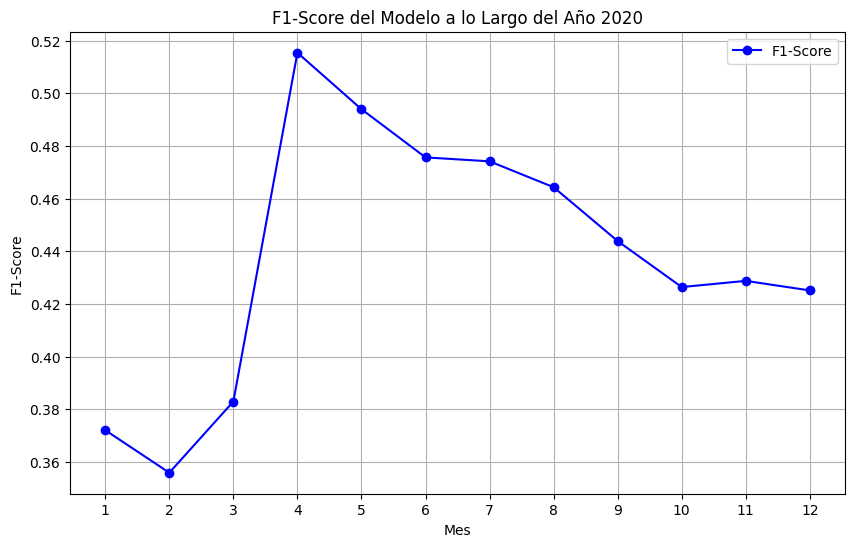

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Preparar los datos
months = np.array(performance_df['Month'])
f1_scores = np.array(performance_df['F1-Score'])

# Crear gráfico
plt.figure(figsize=(10, 6))
plt.plot(months, f1_scores, marker='o', linestyle='-', color='b', label='F1-Score')
plt.title('F1-Score del Modelo a lo Largo del Año 2020')
plt.xlabel('Mes')
plt.ylabel('F1-Score')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)
plt.show()
